# **Habit App - response plots & basic stats**

* This code is sturctured to work using google colab. 
* It is designed to load the data from the drive.
* It build on the data files formed by Habit_app_parse_data.ipynb.
> This code was written by Rani Gera, last editted on November 2022




In [1]:
#@title Load Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Import stuff and general settings

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.patches import Patch
import seaborn as sns
from datetime import datetime, timedelta

In [6]:
#@title Parameter definition { form-width: "5%" }

minSubID = [100, 200, 300]
maxSubID = [199, 299, 399]

# paths:
# main_path = os.path.dirname(os.path.abspath(__file__))
main_path = '/content/drive/MyDrive/Experiments/HAS_STUDY/HAS_Analysis'
filteredDF_File = main_path + '/data/extracted_data/filteredDF.csv'
coreData_File = main_path + '/data/extracted_data/core_table.csv'


# number of experimental days by group:
n_experimental_days = {'short_training': 4, 'long_training': 11, 'long_training_parallel_manipulations': 11}
# number of experimental manipulations per subject:
n_manipulations = {'short_training': 3, 'long_training': 3, 'long_training_parallel_manipulations': 6}

main_manipulation_days = {
    'short_training': {'still_valued': 2, 'devaluation': 3, 'still_valued_post_deval': 4},
    'long_training': {'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},
    'long_training_parallel_manipulations': {'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},  
}

all_manipulation_days = {
    'short_training': {'still_valued': 2, 'devaluation': 3, 'still_valued_post_deval': 4},
    'long_training': {'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},
    'long_training_parallel_manipulations': {'still_valued_week1': 2, 'still_valued_replacing_devaluation': 3, 'still_valued_post_deval_week1': 4, 'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},  
}


dailyOffsetHours = 5 # the time past midnight that is included in the same day (5 means until 5:00 AM is considered the last day)
localTimeZone = "Israel" # used to adjust the time variables which are recorded in utc time.
timeInStringColumns = ['startTime', 'press1Time', 'press2Time', 'outcomeTime', 'endTime', 'userExitOrUnloadTime',
                       'realGameBeginsAlertTime', 'realGameBeginsConfirmationTime', 'resetContainerAlertTime', 'resetContainerConfirmationTime', 'manipulationAlertTime', 'manipulationConfirmationTime', 'foundCaveAlertTime', 'foundCaveConfirmationTime', 'endExperimentAlertTime'] # these variables will be converted to the local time zone and saved as datetime variables


# Figures:
sns.set_theme(context='notebook', style='white')  # options. style: darkgrid, whitegrid, dark, white, ticks | context: paper, notebook, talk, poster

# viewing stuff
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', 40)  # set this number to >= your number of cols
pd.set_option('display.width', 1000)
#pd.describe_option('max_colwidth')
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['timezone'] = localTimeZone


In [7]:
#@title Class definition { form-width: "5%" }
# Define a class to be compatible with the classes' structue in on Habit_app_parse_data.ipynb:
class DataDummy():
    def __init__(self):
        # GET DATA:
        self.sub_df = []


# ------------------------------ * -------------------------------


# LOAD DATA (from the drive)
(and assemble required data [when it is loaded and not extracted])

In [8]:
data=DataDummy()
data.sub_df = pd.read_csv(filteredDF_File,index_col=0,parse_dates=timeInStringColumns)

core_data = pd.read_csv(coreData_File)
core_data = core_data[core_data.time == 'post']
core_data = core_data.drop(columns='time')
core_data = core_data.set_index(['subID', 'group', 'manipulation'])

FileNotFoundError: ignored

In [ ]:
#@title adjustments for working with the data {form-width: "1%"}

core_data_with_diffs = core_data.unstack('manipulation')
core_data_with_diffs.columns = core_data_with_diffs.columns.droplevel()


# ------------------------------ * -------------------------------


# Engagement data

In [ ]:
#@markdown { form-width: "5%" }
total_entries_per_day = pd.DataFrame(data.sub_df.groupby(by=['subId', 'group', 'day']).size().unstack(fill_value=np.nan).stack()).rename(
    columns={0: 'n_entries'}).reset_index().pivot(index='subId', columns=['day'], values='n_entries')

days_data=total_entries_per_day

# dividing to groups:
shortTraining = days_data.loc[(days_data.index > minSubID[0]) & (days_data.index <= maxSubID[0])]
longTraining = days_data.loc[(days_data.index > minSubID[1]) & (days_data.index <= maxSubID[1])]
longTraining_parallelManipulations = days_data.loc[(days_data.index > minSubID[2]) & (days_data.index <= maxSubID[2])]

shortTraining=shortTraining.loc[:,shortTraining.columns[:n_experimental_days['short_training']]]
longTraining=longTraining.loc[:,longTraining.columns[:n_experimental_days['long_training']]]
longTraining_parallelManipulations=longTraining_parallelManipulations.loc[:,longTraining_parallelManipulations.columns[:n_experimental_days['long_training_parallel_manipulations']]]

# get all days' without manipulations across all participants  together:
dailyDataAcrossAll = np.concatenate(
    (longTraining_parallelManipulations[[colname for colname in longTraining_parallelManipulations.columns if colname not in all_manipulation_days['long_training_parallel_manipulations'].values()]].values.flatten(),
     longTraining[[colname for colname in longTraining.columns if colname not in all_manipulation_days['long_training'].values()]].values.flatten(),
     shortTraining[[colname for colname in shortTraining.columns if colname not in all_manipulation_days['short_training'].values()]].values.flatten()),
     )

dailyDataAcrossAll.sort()
med95CIupper = np.median(dailyDataAcrossAll) + 1.57 * (np.percentile(dailyDataAcrossAll,75) - np.percentile(dailyDataAcrossAll,25))/np.sqrt(len(dailyDataAcrossAll))
med95CIlower = np.median(dailyDataAcrossAll) - 1.57 * (np.percentile(dailyDataAcrossAll,75) - np.percentile(dailyDataAcrossAll,25))/np.sqrt(len(dailyDataAcrossAll))

print(f'Mean = {dailyDataAcrossAll.mean()}')
print(f'STD = {dailyDataAcrossAll.std()}')
print(f'STD ERR = {stats.sem(dailyDataAcrossAll)}')
print(f'Median = {np.median(dailyDataAcrossAll)}')
print(f'Estimated 95% CI around the median  = [{med95CIlower},{med95CIupper}]') #https://stats.stackexchange.com/questions/184516/why-is-the-95-ci-for-the-median-supposed-to-be-%C2%B11-57iqr-sqrtn

Mean = 122.18709677419355
STD = 180.74319822464827
STD ERR = 7.264682498254377
Median = 53.5
Estimated 95% CI around the median  = [45.91791074240875,61.08208925759125]


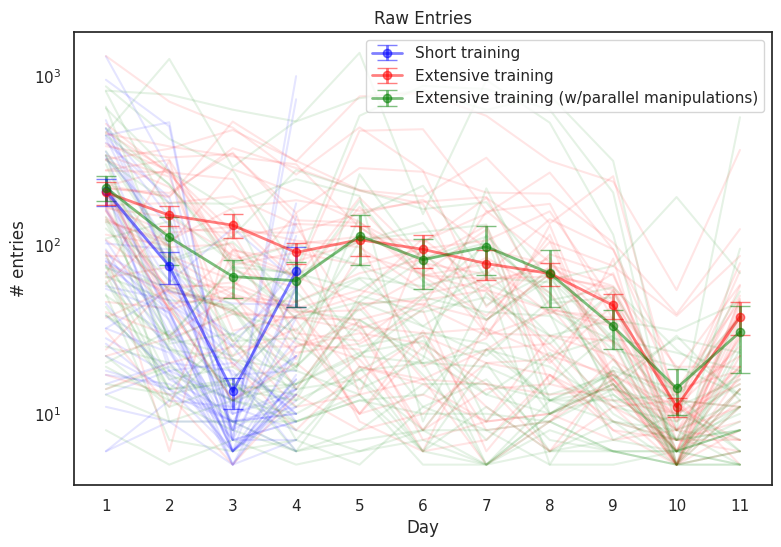

In [ ]:
#@title Plot mean daily entries { form-width: "5%" }
total_entries_per_day = pd.DataFrame(data.sub_df.groupby(by=['subId', 'group', 'day']).size().unstack(fill_value=np.nan).stack()).rename(
    columns={0: 'n_entries'}).reset_index().pivot(index='subId', columns=['day'], values='n_entries')

# create 'learning' curve figure (using inner function):
# -------------------------------------------------------
# parameters:
days_data=total_entries_per_day
individualLines=True
plotGeneralMean=False

# dividing to groups:
shortTraining = days_data.loc[(days_data.index > minSubID[0]) & (days_data.index <= maxSubID[0])]
longTraining = days_data.loc[(days_data.index > minSubID[1]) & (days_data.index <= maxSubID[1])]
longTraining_parallelManipulations = days_data.loc[(days_data.index > minSubID[2]) & (days_data.index <= maxSubID[2])]

shortTraining=shortTraining.loc[:,shortTraining.columns[:n_experimental_days['short_training']]]
longTraining=longTraining.loc[:,longTraining.columns[:n_experimental_days['long_training']]]
longTraining_parallelManipulations=longTraining_parallelManipulations.loc[:,longTraining_parallelManipulations.columns[:n_experimental_days['long_training_parallel_manipulations']]]

# get the means and fill empty days with zero (in case participants entered following the experiment completion)
daysDataMean=days_data.mean(skipna=True)
daysDataSEM=days_data.sem(skipna=True)
for i in range(int(daysDataMean.index.max())):
  if i+1 not in daysDataMean.index:
    daysDataMean[float(i+1)]=0
    daysDataSEM[float(i+1)]=0
daysDataMean.sort_index()
daysDataSEM.sort_index()

shortTrainingMean=shortTraining.mean(skipna=True)
shortTrainingSEM=shortTraining.sem(skipna=True)
shortTrainingSTD=shortTraining.std(skipna=True)
for i in range(int(shortTrainingMean.index.max())):
  if i+1 not in shortTrainingMean.index or np.isnan(shortTrainingMean[float(i+1)]):
    shortTrainingMean[float(i+1)]=0
    shortTrainingSEM[float(i+1)]=0
    shortTrainingSTD[float(i+1)]=0
shortTrainingMean = shortTrainingMean.sort_index()
shortTrainingSEM = shortTrainingSEM.sort_index()
shortTrainingSTD = shortTrainingSTD.sort_index()


longTrainingMean=longTraining.mean(skipna=True)
longTrainingSEM=longTraining.sem(skipna=True)
longTrainingSTD=longTraining.std(skipna=True)
for i in range(int(longTrainingMean.index.max())):
  if i+1 not in longTrainingMean.index or np.isnan(longTrainingMean[float(i+1)]):
    longTrainingMean[float(i+1)]=0
    longTrainingSEM[float(i+1)]=0
    longTrainingSTD[float(i+1)]=0
longTrainingMean = longTrainingMean.sort_index()
longTrainingSEM = longTrainingSEM.sort_index()
longTrainingSTD = longTrainingSTD.sort_index()


longTrainingMeanParallelManipulationsMean=longTraining_parallelManipulations.mean(skipna=True)
longTrainingMeanParallelManipulationsSEM=longTraining_parallelManipulations.sem(skipna=True)
longTrainingMeanParallelManipulationsSTD=longTraining_parallelManipulations.std(skipna=True)
for i in range(int(longTrainingMeanParallelManipulationsMean.index.max())):
  if i+1 not in longTrainingMeanParallelManipulationsMean.index or np.isnan(longTrainingMeanParallelManipulationsMean[float(i+1)]):
    longTrainingMeanParallelManipulationsMean[float(i+1)]=0
    longTrainingMeanParallelManipulationsSEM[float(i+1)]=0
    longTrainingMeanParallelManipulationsSTD[float(i+1)]=0
longTrainingMeanParallelManipulationsMean = longTrainingMeanParallelManipulationsMean.sort_index()
longTrainingMeanParallelManipulationsSEM = longTrainingMeanParallelManipulationsSEM.sort_index()
longTrainingMeanParallelManipulationsSTD = longTrainingMeanParallelManipulationsSTD.sort_index()


# plot
plt.figure()
if individualLines:  # create individual lines
    plt.plot(shortTraining.T, color='blue', alpha=0.1)
    plt.plot(longTraining.T, color='red', alpha=0.1)
    plt.plot(longTraining_parallelManipulations.T, color='green', alpha=0.1)

# mean lines
if plotGeneralMean:
  plt.errorbar(daysDataMean.index, daysDataMean, color='black', label='All', yerr=daysDataSEM, capsize=7, alpha=0.5, marker='o', linewidth=2)
plt.errorbar(shortTrainingMean.index, shortTrainingMean, color='blue', label='Short training', yerr=shortTrainingSEM, capsize=7, alpha=0.5, marker='o', linewidth=2)
plt.errorbar(longTrainingMean.index, longTrainingMean, color='red', label='Extensive training', yerr=longTrainingSEM, capsize=7, alpha=0.5, marker='o', linewidth=2)
plt.errorbar(longTrainingMeanParallelManipulationsMean.index, longTrainingMeanParallelManipulationsMean, color='green', label='Extensive training (w/parallel manipulations)', yerr=longTrainingMeanParallelManipulationsSEM, capsize=7, alpha=0.5, marker='o', linewidth=2)

plt.legend()
plt.xlabel('Day')
plt.ylabel('# entries')
plt.title('Raw Entries')

plt.yscale('log')
plt.xticks(range(1,12))
plt.savefig('daily entries.png', dpi=300, format='png')
plt.show()


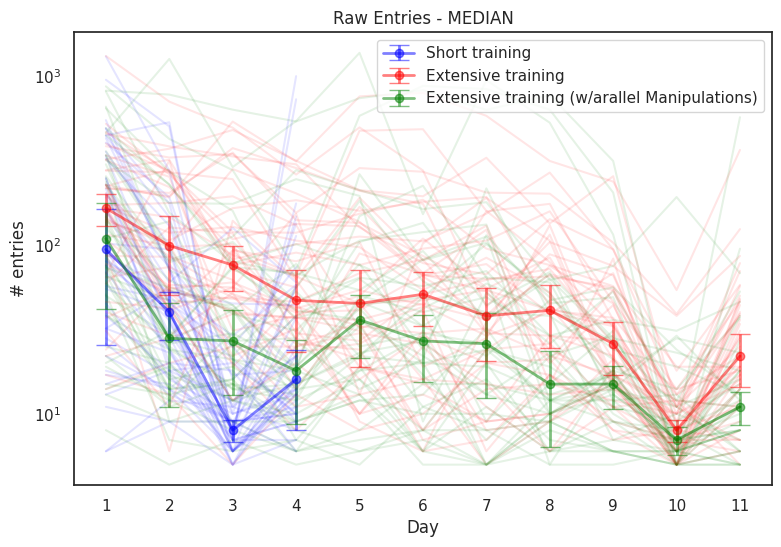

In [ ]:
#@title Median with eror bars of 95% CIs (calculated like barplot notches) { form-width: "5%" }
total_entries_per_day = pd.DataFrame(data.sub_df.groupby(by=['subId', 'group', 'day']).size().unstack(fill_value=np.nan).stack()).rename(
    columns={0: 'n_entries'}).reset_index().pivot(index='subId', columns=['day'], values='n_entries')

# parameters:
days_data=total_entries_per_day
individualLines=True

# dividing to groups:
shortTraining = days_data.loc[(days_data.index > minSubID[0]) & (days_data.index <= maxSubID[0])]
longTraining = days_data.loc[(days_data.index > minSubID[1]) & (days_data.index <= maxSubID[1])]
longTraining_parallelManipulations = days_data.loc[(days_data.index > minSubID[2]) & (days_data.index <= maxSubID[2])]

shortTraining=shortTraining.loc[:,shortTraining.columns[:n_experimental_days['short_training']]]
longTraining=longTraining.loc[:,longTraining.columns[:n_experimental_days['long_training']]]
longTraining_parallelManipulations=longTraining_parallelManipulations.loc[:,longTraining_parallelManipulations.columns[:n_experimental_days['long_training_parallel_manipulations']]]

shortTrainingMedian=shortTraining.median(skipna=True)
for i in range(int(shortTrainingMedian.index.max())):
  if i+1 not in shortTrainingMedian.index or np.isnan(shortTrainingMedian[float(i+1)]):
    shortTrainingMedian[float(i+1)]=0
shortTrainingMedian = shortTrainingMedian.sort_index()

longTrainingMedian=longTraining.median(skipna=True)
for i in range(int(longTrainingMedian.index.max())):
  if i+1 not in longTrainingMedian.index or np.isnan(longTrainingMedian[float(i+1)]):
    longTrainingMedian[float(i+1)]=0
longTrainingMedian = longTrainingMedian.sort_index()

longTrainingMeanParallelManipulationsMedian=longTraining_parallelManipulations.median(skipna=True)
for i in range(int(longTrainingMeanParallelManipulationsMedian.index.max())):
  if i+1 not in longTrainingMeanParallelManipulationsMedian.index or np.isnan(longTrainingMeanParallelManipulationsMedian[float(i+1)]):
    longTrainingMeanParallelManipulationsMedian[float(i+1)]=0
longTrainingMeanParallelManipulationsMedian = longTrainingMeanParallelManipulationsMedian.sort_index()


# plot
plt.figure()
if individualLines:  # create individual lines
    plt.plot(shortTraining.T, color='blue', alpha=0.1)
    plt.plot(longTraining.T, color='red', alpha=0.1)
    plt.plot(longTraining_parallelManipulations.T, color='green', alpha=0.1)

shortCIs = shortTraining.values
shortCIs.sort(axis=0)
s_med95CIupper = np.median(shortCIs,axis=0) + 1.57 * (np.percentile(shortCIs,75,axis=0) - np.percentile(shortCIs,25,axis=0))/np.sqrt(shortCIs.shape[0])
s_med95CIlower = np.median(shortCIs,axis=0) - 1.57 * (np.percentile(shortCIs,75,axis=0) - np.percentile(shortCIs,25,axis=0))/np.sqrt(shortCIs.shape[0])

longCIs = longTraining.values
longCIs.sort(axis=0)
l_med95CIupper = np.median(longCIs,axis=0) + 1.57 * (np.percentile(longCIs,75,axis=0) - np.percentile(longCIs,25,axis=0))/np.sqrt(longCIs.shape[0])
l_med95CIlower = np.median(longCIs,axis=0) - 1.57 * (np.percentile(longCIs,75,axis=0) - np.percentile(longCIs,25,axis=0))/np.sqrt(longCIs.shape[0])

longParCIs = longTraining_parallelManipulations.values
longParCIs.sort(axis=0)
lp_med95CIupper = np.median(longParCIs,axis=0) + 1.57 * (np.percentile(longParCIs,75,axis=0) - np.percentile(longParCIs,25,axis=0))/np.sqrt(longParCIs.shape[0])
lp_med95CIlower = np.median(longParCIs,axis=0) - 1.57 * (np.percentile(longParCIs,75,axis=0) - np.percentile(longParCIs,25,axis=0))/np.sqrt(longParCIs.shape[0])


short_err = np.concatenate((np.array([s_med95CIlower]),np.array([s_med95CIupper])))
long_err = np.concatenate((np.array([l_med95CIlower]),np.array([l_med95CIupper])))
longPar_err = np.concatenate((np.array([lp_med95CIlower]),np.array([lp_med95CIupper])))

short_err2 = pd.concat([shortTrainingMedian-short_err[0,:], short_err[1,:]-shortTrainingMedian],axis=1).transpose().to_numpy()
long_err2 = pd.concat([longTrainingMedian-long_err[0,:], long_err[1,:]-longTrainingMedian],axis=1).transpose().to_numpy()
longPar_err2 = pd.concat([longTrainingMeanParallelManipulationsMedian-longPar_err[0,:], longPar_err[1,:]-longTrainingMeanParallelManipulationsMedian],axis=1).transpose().to_numpy()


plt.errorbar(shortTrainingMedian.index, shortTrainingMedian, color='blue', label='Short training', yerr=short_err2, capsize=7, alpha=0.5, marker='o', linewidth=2)
plt.errorbar(longTrainingMedian.index, longTrainingMedian, color='red', label='Extensive training', yerr=long_err2, capsize=7, alpha=0.5, marker='o', linewidth=2)
plt.errorbar(longTrainingMeanParallelManipulationsMedian.index, longTrainingMeanParallelManipulationsMedian, color='green', label='Extensive training (w/arallel Manipulations)', yerr=longPar_err2, capsize=7, alpha=0.5, marker='o', linewidth=2)


plt.legend()
plt.xlabel('Day')
plt.ylabel('# entries')
plt.title('Raw Entries - MEDIAN')

plt.xticks(range(1,12))
plt.yscale('log')
plt.show()


# Event plots

>>> Create a new data variable with times in common time (i.e., day one is set to same date etc.)
>>> Creating a dictionary with the relevant data.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:217: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:227: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


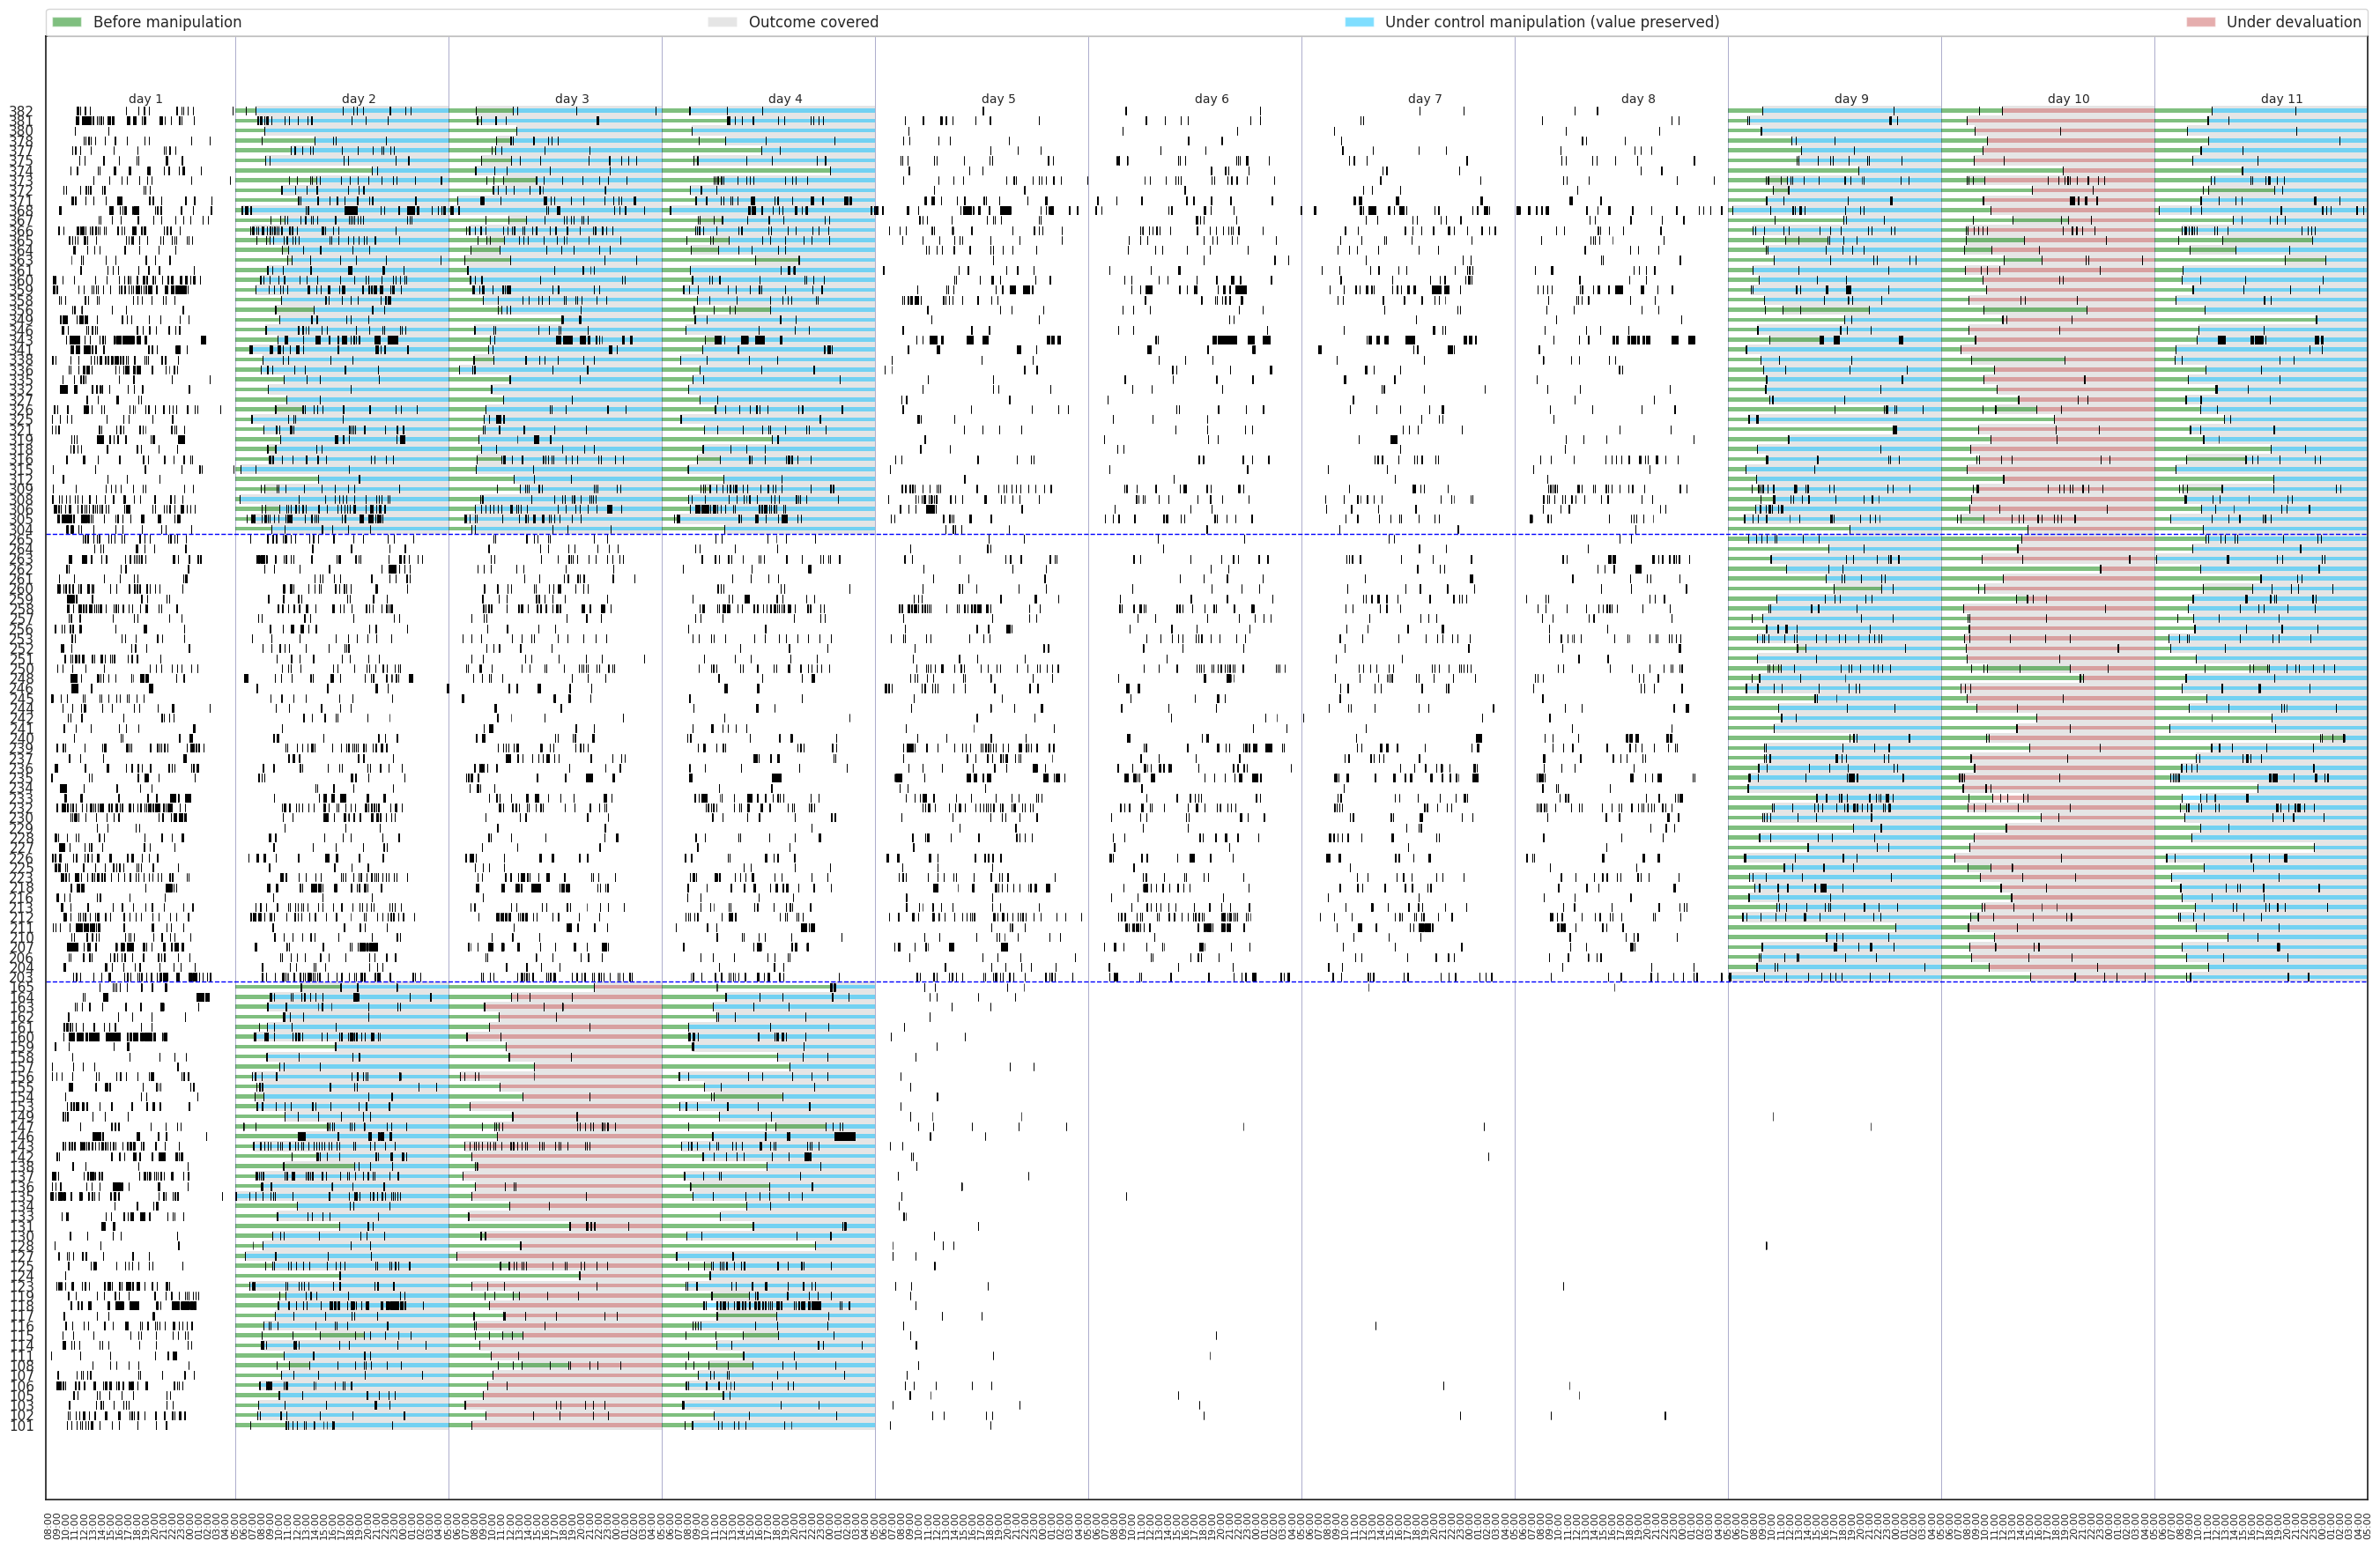

In [ ]:
#@title event plots across all days { form-width: "5%" }
sns.set_theme(style="white")

def plotEvents(differentiatePressesByColor = True, differentiatePressesByLineHeight = True, showOnlyAlignedManipulationDays = False, figSize = (12,5), daysRange = (1,12)):
  '''
  This fucntion plot the events during the app in a given range or alternatively only of the manipulation days (when showOnlyAlignedManipulationDays = True).
  The range of the days shown is indicated in daysRange(first day, last day) in case showOnlyAlignedManipulationDays=False.
  It can use different colors to indicate whether the event is includes only entering, press once or pressed twice (when differentiatePressesByColor = True and/or differentiatePressesByLineHeight = False).
  * showOnlyAlignedManipulationDays = True daysRange is redundant.

  *** IMPORTANT ***
  To edit if necessary:
  In some cases additional editing of the legend is required
  '''
  # Parameters:
  # ------------------------
  # labels:
  xlabelFontSize = 8
  line_colors = [[1,0.8,0],[1,0.4,0],[1,0,0]] if differentiatePressesByColor else ['black'] * 3
  # colors:
  outcome_covered_color = {'color': 'gray', 'alpha': 0.2}
  before_manipulation_activated_color = {'color': 'green', 'alpha': 0.5}
  under_still_devalued_control_color = {'color': 'deepskyblue', 'alpha': 0.5}
  under_devaluation_color = {'color': 'indianred', 'alpha': 0.5}
  # event lines:
  linelengths = [0.4, 0.6, 0.8] if differentiatePressesByLineHeight else [0.8] * 3
  linewidth = 0.5
  # days range to present (if showOnlyAlignedManipulationDays=False)
  daysRange = (1,3) if showOnlyAlignedManipulationDays else daysRange
  # number of potential subject IDs in each group (i.e., every 100 or every 1000)
  potentialSubIdsPerGroup = 100

  # HANDLE DATA:
  # ------------------------
  # create a common time for all participants (using a mode starting date)
  print('>>> Create a new data variable with times in common time (i.e., day one is set to same date etc.)')
  commonTimeDF = data.sub_df.copy()
  if showOnlyAlignedManipulationDays:
    commonTimeDF = commonTimeDF[(commonTimeDF['manipulationToday']=='still_valued') | (commonTimeDF['manipulationToday']=='devaluation') | (commonTimeDF['manipulationToday']=='still_valued_post_deval')]
    commonTimeDF.loc[commonTimeDF['manipulationToday']=='still_valued','day'] = 1
    commonTimeDF.loc[commonTimeDF['manipulationToday']=='devaluation','day'] = 2
    commonTimeDF.loc[commonTimeDF['manipulationToday']=='still_valued_post_deval','day'] = 3

  for timeVar in timeInStringColumns:
    for i,x in enumerate(commonTimeDF[timeVar]):
      if not pd.isnull(x):
        try:
          commonTimeDF.iloc[i, commonTimeDF.columns.get_loc(timeVar)] = (x - timedelta(hours=dailyOffsetHours)).replace(year=2000,month=1,day=int(commonTimeDF.day.iloc[i])) + timedelta(hours=dailyOffsetHours)
        except Exception as e:
          print('>>> A problem in converting element ' + str(i) + ' in ' + str(timeVar) + ' of the specified time ' + str(x) + '.')
          print('>>> Error type: ' + str(e))


  subjects = commonTimeDF.subId.unique()
  n_subjects = len(subjects)
  lineoffsets = np.linspace(start=1, stop=n_subjects, num=n_subjects)

  # Create time dict of all subjects. The times extracted are the startTime in all cases.
  print('>>> Creating a dictionary with the relevant data.')
  timeDict = {}
  for sub in subjects:
    timeDict[sub] = {
        'startTime': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.startTime.isna())].startTime, #get when there was startTime
        'startTimeFollowedBy1Press': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.press1Time.isna())].startTime, #get when there was press1Time
        'startTimeFollowedBy2Presses': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.press2Time.isna())].startTime, #get when there was press2Time
        'cloudsStartTimes': [],
        'still_valued_indicationTrialEndTime': {'day': [], 'time': []},
        'devaluation_indicationTrialEndTime': {'day': [], 'time': []},
        'valued_AGAIN_indicationTrialEndTime': {'day': [], 'time': []},
        'still_valued_week1_indicationTrialEndTime': {'day': [], 'time': []},
        'still_valued_replacing_devaluation_indicationTrialEndTime': {'day': [], 'time': []},
        'still_valued_post_deval_week1_indicationTrialEndTime': {'day': [], 'time': []},
    }
    for day in commonTimeDF.day.unique():
      if not commonTimeDF[(commonTimeDF.subId==sub) &(commonTimeDF.day==day) & (commonTimeDF.hideOutcome == True)].empty:
        timeDict[sub]['cloudsStartTimes'].append(commonTimeDF[(commonTimeDF.subId==sub) &(commonTimeDF.day==day) & (commonTimeDF.hideOutcome == True)].iloc[0].startTime)
    
    still_valued_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    timeDict[sub]['still_valued_indicationTrialEndTime']['time'] = still_valued_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['still_valued_indicationTrialEndTime']['day'] = still_valued_indicationTrialEndTime_row.day

    devaluation_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='devaluation') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    timeDict[sub]['devaluation_indicationTrialEndTime']['time'] = devaluation_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['devaluation_indicationTrialEndTime']['day'] = devaluation_indicationTrialEndTime_row.day

    valued_AGAIN_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued_post_deval') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['time'] = valued_AGAIN_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['day'] = valued_AGAIN_indicationTrialEndTime_row.day

    # The parallel manipulations:
    still_valued_week1_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued_week1') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    timeDict[sub]['still_valued_week1_indicationTrialEndTime']['time'] = still_valued_week1_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['still_valued_week1_indicationTrialEndTime']['day'] = still_valued_week1_indicationTrialEndTime_row.day

    still_valued_replacing_devaluation_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued_replacing_devaluation') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    timeDict[sub]['still_valued_replacing_devaluation_indicationTrialEndTime']['time'] = still_valued_replacing_devaluation_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['still_valued_replacing_devaluation_indicationTrialEndTime']['day'] = still_valued_replacing_devaluation_indicationTrialEndTime_row.day

    still_valued_post_deval_week1_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued_post_deval_week1') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    timeDict[sub]['still_valued_post_deval_week1_indicationTrialEndTime']['time'] = still_valued_post_deval_week1_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['still_valued_post_deval_week1_indicationTrialEndTime']['day'] = still_valued_post_deval_week1_indicationTrialEndTime_row.day

  # CREATE THE PLOT:
  # ------------------------
  fig, axs = plt.subplots()
  # create a raster plot of app entries (including the their number of presses)
  for idx, sub in enumerate(timeDict.keys()):
    axs.eventplot(timeDict[sub]['startTime'], colors=line_colors[0], lineoffsets=lineoffsets[idx] - (linelengths[2]-linelengths[0])/2,
                        linelengths=linelengths[0], linewidths=linewidth)
    axs.eventplot(timeDict[sub]['startTimeFollowedBy1Press'], colors=line_colors[1], lineoffsets=lineoffsets[idx] - (linelengths[2]-linelengths[1])/2,
                        linelengths=linelengths[1], linewidths=linewidth)
    axs.eventplot(timeDict[sub]['startTimeFollowedBy2Presses'], colors=line_colors[2], lineoffsets=lineoffsets[idx],
                        linelengths=linelengths[2], linewidths=linewidth)

  plt.yticks(np.arange(1, n_subjects+1, step=1))
  axs.set_yticklabels(subjects)

  axs.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
  axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  axs.set_xlim(left = min(commonTimeDF[commonTimeDF.day >= daysRange[0]].startTime) - timedelta(hours=0.5), right = max(commonTimeDF[commonTimeDF.day <= daysRange[1]].startTime) + timedelta(hours=0.5))
  plt.xticks(fontsize = xlabelFontSize)
  plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)

  # figure setup and drawing 
  fig.set_size_inches(figSize)
  fig.canvas.draw()
  xlim = axs.get_xlim()

  # indicate seperate days (with a seperating line) and get the relevant xticks values:
  endOfDayXTicks = []
  middleOfDayXTicks = []
  dayInd = daysRange[0]
  for xtick in axs.get_xticklabels():
    if xtick.get_text()=='05:00': # create seperating lines between days
      xtick_x_value = xtick.get_unitless_position()[0]
      axs.axvline(x=xtick_x_value, color = 'midnightblue', alpha=0.5, linewidth=0.5)
      endOfDayXTicks.append(xtick_x_value)
    elif xtick.get_text()=='17:00': # add days inside mini titles:
      if showOnlyAlignedManipulationDays:
        dayTitle = ['still-valued','devalued', 'valued again'][dayInd-1]
      else:
        dayTitle = 'day ' + str(dayInd)
      axs.text(xtick.get_unitless_position()[0], n_subjects+0.8,dayTitle,fontsize=10)
      dayInd+=1
      middleOfDayXTicks.append(xtick.get_unitless_position()[0])

  # draw a line seperating between the groups:
  y_labels=np.array([int(y_label.get_text()) for y_label in axs.get_yticklabels()])
  y_labels_Xpos = [y_label.get_unitless_position()[1] for y_label in axs.get_yticklabels()]
  # group_seperator_y = (y_labels_Xpos[np.where(y_labels==max(commonTimeDF[commonTimeDF.group=='short_training'].subId))[0][0]] +
  #                      y_labels_Xpos[np.where(y_labels==min(commonTimeDF[commonTimeDF.group=='long_training'].subId))[0][0]]) / 2
  ##import pdb
  ##pdb.set_trace()
  if len(data.sub_df.group.unique()) != 1: # if there is more than one group
    #group_seperator_y = (y_labels_Xpos[np.where(y_labels%(2*potentialSubIdsPerGroup) > potentialSubIdsPerGroup)[0][-1]] + y_labels_Xpos[np.where(y_labels%200 < 100)[0][0]])/2
    n_short = (commonTimeDF.subId.unique()<200).sum()
    n_long = ((commonTimeDF.subId.unique()>200) & (commonTimeDF.subId.unique()<300)).sum()
    axs.axhline(y=n_short + n_long + 0.5, color = 'blue', alpha=1, linewidth=1, linestyle='--')
    axs.axhline(y=n_short + 0.5, color = 'blue', alpha=1, linewidth=1, linestyle='--')

  # add rectangles that indicate outcome hiding (clouds) and manipulation (before/after):
  for i, sub in enumerate(subjects):
    # place cloud rectangles:
    for hidingStartTime in timeDict[sub]['cloudsStartTimes']:
      x_position_of_hidingStartTime = mdates.date2num(hidingStartTime)
      if xlim[0] < x_position_of_hidingStartTime < xlim[1]: # check if in range of the plot 
        # Create a Rectangle patch
        rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_hidingStartTime][0] if [x for x in endOfDayXTicks if x >= x_position_of_hidingStartTime] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
        rectCloudy = patches.Rectangle((x_position_of_hidingStartTime, lineoffsets[i]-0.5), rectRightEndingPoint - x_position_of_hidingStartTime, 1,linewidth=1,edgecolor='none',facecolor=outcome_covered_color['color'], alpha=outcome_covered_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
        # Add the patch to the Axes
        axs.add_patch(rectCloudy)    
    # place manipulations - still valued:
    x_position_of_still_valued =  mdates.date2num(timeDict[sub]['still_valued_indicationTrialEndTime']['time'])
    if (xlim[0] < x_position_of_still_valued < xlim[1]) & (x_position_of_still_valued.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectStillValued = patches.Rectangle((x_position_of_still_valued, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_still_valued, 0.4,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_still_valued - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValuedBefore)
    # place manipulations - devaluation:
    x_position_of_devaluation =  mdates.date2num(timeDict[sub]['devaluation_indicationTrialEndTime']['time'])
    if (xlim[0] < x_position_of_devaluation < xlim[1]) & (x_position_of_devaluation.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_devaluation][0] if [x for x in endOfDayXTicks if x >= x_position_of_devaluation] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectDevalued = patches.Rectangle((x_position_of_devaluation, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_devaluation, 0.4,linewidth=0,edgecolor='none',facecolor=under_devaluation_color['color'], alpha=under_devaluation_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectDevalued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_devaluation][-1] if [x for x in endOfDayXTicks if x <= x_position_of_devaluation] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectDevaluedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_devaluation - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectDevaluedBefore)
    # place manipulations - still valued AGAIN:
    x_position_of_still_valued_again =  mdates.date2num(timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['time'])
    if (xlim[0] < x_position_of_still_valued_again < xlim[1]) & (x_position_of_still_valued_again.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectStillValued = patches.Rectangle((x_position_of_still_valued_again, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_still_valued_again, 0.4,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_still_valued_again - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValuedBefore)

    # Add parallel manipulations:
    # place manipulations - still valued week 1:
    x_position_of_still_valued =  mdates.date2num(timeDict[sub]['still_valued_week1_indicationTrialEndTime']['time'])
    if (xlim[0] < x_position_of_still_valued < xlim[1]) & (x_position_of_still_valued.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectStillValued = patches.Rectangle((x_position_of_still_valued, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_still_valued, 0.4,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_still_valued - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValuedBefore)
    # place manipulations - parallel to devaluation week 1:
    x_position_of_devaluation =  mdates.date2num(timeDict[sub]['still_valued_replacing_devaluation_indicationTrialEndTime']['time'])
    if (xlim[0] < x_position_of_devaluation < xlim[1]) & (x_position_of_devaluation.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_devaluation][0] if [x for x in endOfDayXTicks if x >= x_position_of_devaluation] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectDevalued = patches.Rectangle((x_position_of_devaluation, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_devaluation, 0.4,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectDevalued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_devaluation][-1] if [x for x in endOfDayXTicks if x <= x_position_of_devaluation] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectDevaluedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_devaluation - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectDevaluedBefore)
    # place manipulations - still valued AGAIN week 1:
    x_position_of_still_valued_again =  mdates.date2num(timeDict[sub]['still_valued_post_deval_week1_indicationTrialEndTime']['time'])
    if (xlim[0] < x_position_of_still_valued_again < xlim[1]) & (x_position_of_still_valued_again.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectStillValued = patches.Rectangle((x_position_of_still_valued_again, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_still_valued_again, 0.4,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_still_valued_again - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValuedBefore)

  # handle legends:
  legend_elements = [Patch(facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'], label='Before manipulation'),
                    Patch(facecolor=outcome_covered_color['color'], alpha=outcome_covered_color['alpha'], label='Outcome covered'),
                    Patch(facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'], label='Under control manipulation (value preserved)'),
                    Patch(facecolor=under_devaluation_color['color'], alpha=under_devaluation_color['alpha'], label='Under devaluation')]
  axs.legend(handles=legend_elements, bbox_to_anchor=(0, 1.0, 1., 0.01), ncol=4, mode="expand", borderaxespad=0., fontsize=12)

  plt.show()
  return timeDict

timeDict=plotEvents(differentiatePressesByColor = False, differentiatePressesByLineHeight = False, showOnlyAlignedManipulationDays = False, figSize = (34,22), daysRange = (1,n_experimental_days['long_training']))


# Event + Density plot

In [ ]:
#@title assemble the relevant data { form-width: "5%" }

differentiatePressesByColor = True
differentiatePressesByLineHeight = False
showOnlyAlignedManipulationDays = True
figSize = (30,12)
daysRange = (1,12)

# PREPARE THE DATA:
# ------------------------
# create a common time for all participants (using a mode starting date)
print('>>> Create a new data variable with times in common time (i.e., day one is set to same date etc.)')
commonTimeDF = data.sub_df.copy()
if showOnlyAlignedManipulationDays:
  commonTimeDF = commonTimeDF[(commonTimeDF['manipulationToday']=='still_valued') | (commonTimeDF['manipulationToday']=='devaluation') | (commonTimeDF['manipulationToday']=='still_valued_post_deval')]
  commonTimeDF.loc[commonTimeDF['manipulationToday']=='still_valued','day'] = 1
  commonTimeDF.loc[commonTimeDF['manipulationToday']=='devaluation','day'] = 2
  commonTimeDF.loc[commonTimeDF['manipulationToday']=='still_valued_post_deval','day'] = 3

for timeVar in timeInStringColumns:
  for i,x in enumerate(commonTimeDF[timeVar]):
    if not pd.isnull(x):
      try:
        commonTimeDF.iloc[i, commonTimeDF.columns.get_loc(timeVar)] = (x - timedelta(hours=dailyOffsetHours)).replace(year=2000,month=1,day=int(commonTimeDF.day.iloc[i])) + timedelta(hours=dailyOffsetHours)
      except Exception as e:
        print('>>> A problem in converting element ' + str(i) + ' in ' + str(timeVar) + ' of the specified time ' + str(x) + '.')
        print('>>> Error type: ' + str(e))


subjects = commonTimeDF.subId.unique()
n_subjects = len(subjects)

# Create time dict of all subjects. The times extracted are the startTime in all cases.
print('>>> Creating a dictionary with the relevant data.')
timeDict = {}
for sub in subjects:
  timeDict[sub] = {
      'startTime': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.startTime.isna())].startTime, #get when there was startTime
      'startTimeFollowedBy1Press': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.press1Time.isna())].startTime, #get when there was press1Time
      'startTimeFollowedBy2Presses': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.press2Time.isna())].startTime, #get when there was press2Time
      'cloudsStartTimes': [],
      'still_valued_indicationTrialEndTime': {'day': [], 'time': []},
      'devaluation_indicationTrialEndTime': {'day': [], 'time': []},
      'valued_AGAIN_indicationTrialEndTime': {'day': [], 'time': []},
  }
  for day in commonTimeDF.day.unique():
    if not commonTimeDF[(commonTimeDF.subId==sub) &(commonTimeDF.day==day) & (commonTimeDF.hideOutcome == True)].empty:
      timeDict[sub]['cloudsStartTimes'].append(commonTimeDF[(commonTimeDF.subId==sub) &(commonTimeDF.day==day) & (commonTimeDF.hideOutcome == True)].iloc[0].startTime)
  
  still_valued_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
  timeDict[sub]['still_valued_indicationTrialEndTime']['time'] = still_valued_indicationTrialEndTime_row.manipulationConfirmationTime
  timeDict[sub]['still_valued_indicationTrialEndTime']['day'] = still_valued_indicationTrialEndTime_row.day

  devaluation_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='devaluation') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
  timeDict[sub]['devaluation_indicationTrialEndTime']['time'] = devaluation_indicationTrialEndTime_row.manipulationConfirmationTime
  timeDict[sub]['devaluation_indicationTrialEndTime']['day'] = devaluation_indicationTrialEndTime_row.day

  valued_AGAIN_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued_post_deval') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
  timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['time'] = valued_AGAIN_indicationTrialEndTime_row.manipulationConfirmationTime
  timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['day'] = valued_AGAIN_indicationTrialEndTime_row.day

timeSeries = {'short': [], 'long': [], 'long_parallel': []}
for key in timeDict.keys():
  if key < 200:
    timeSeries['short'] += list(timeDict[key]['startTime'])
  elif key > 300:
    timeSeries['long_parallel'] += list(timeDict[key]['startTime'])
  else:
    timeSeries['long'] += list(timeDict[key]['startTime'])

timeSeriesDF=pd.melt(pd.DataFrame.from_dict(timeSeries,orient='index').transpose(), value_vars=['short', 'long', 'long_parallel'], var_name='group',value_name='entry_time')
timeSeriesDF=timeSeriesDF[timeSeriesDF.entry_time.notna()]



>>> Create a new data variable with times in common time (i.e., day one is set to same date etc.)
>>> Creating a dictionary with the relevant data.


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


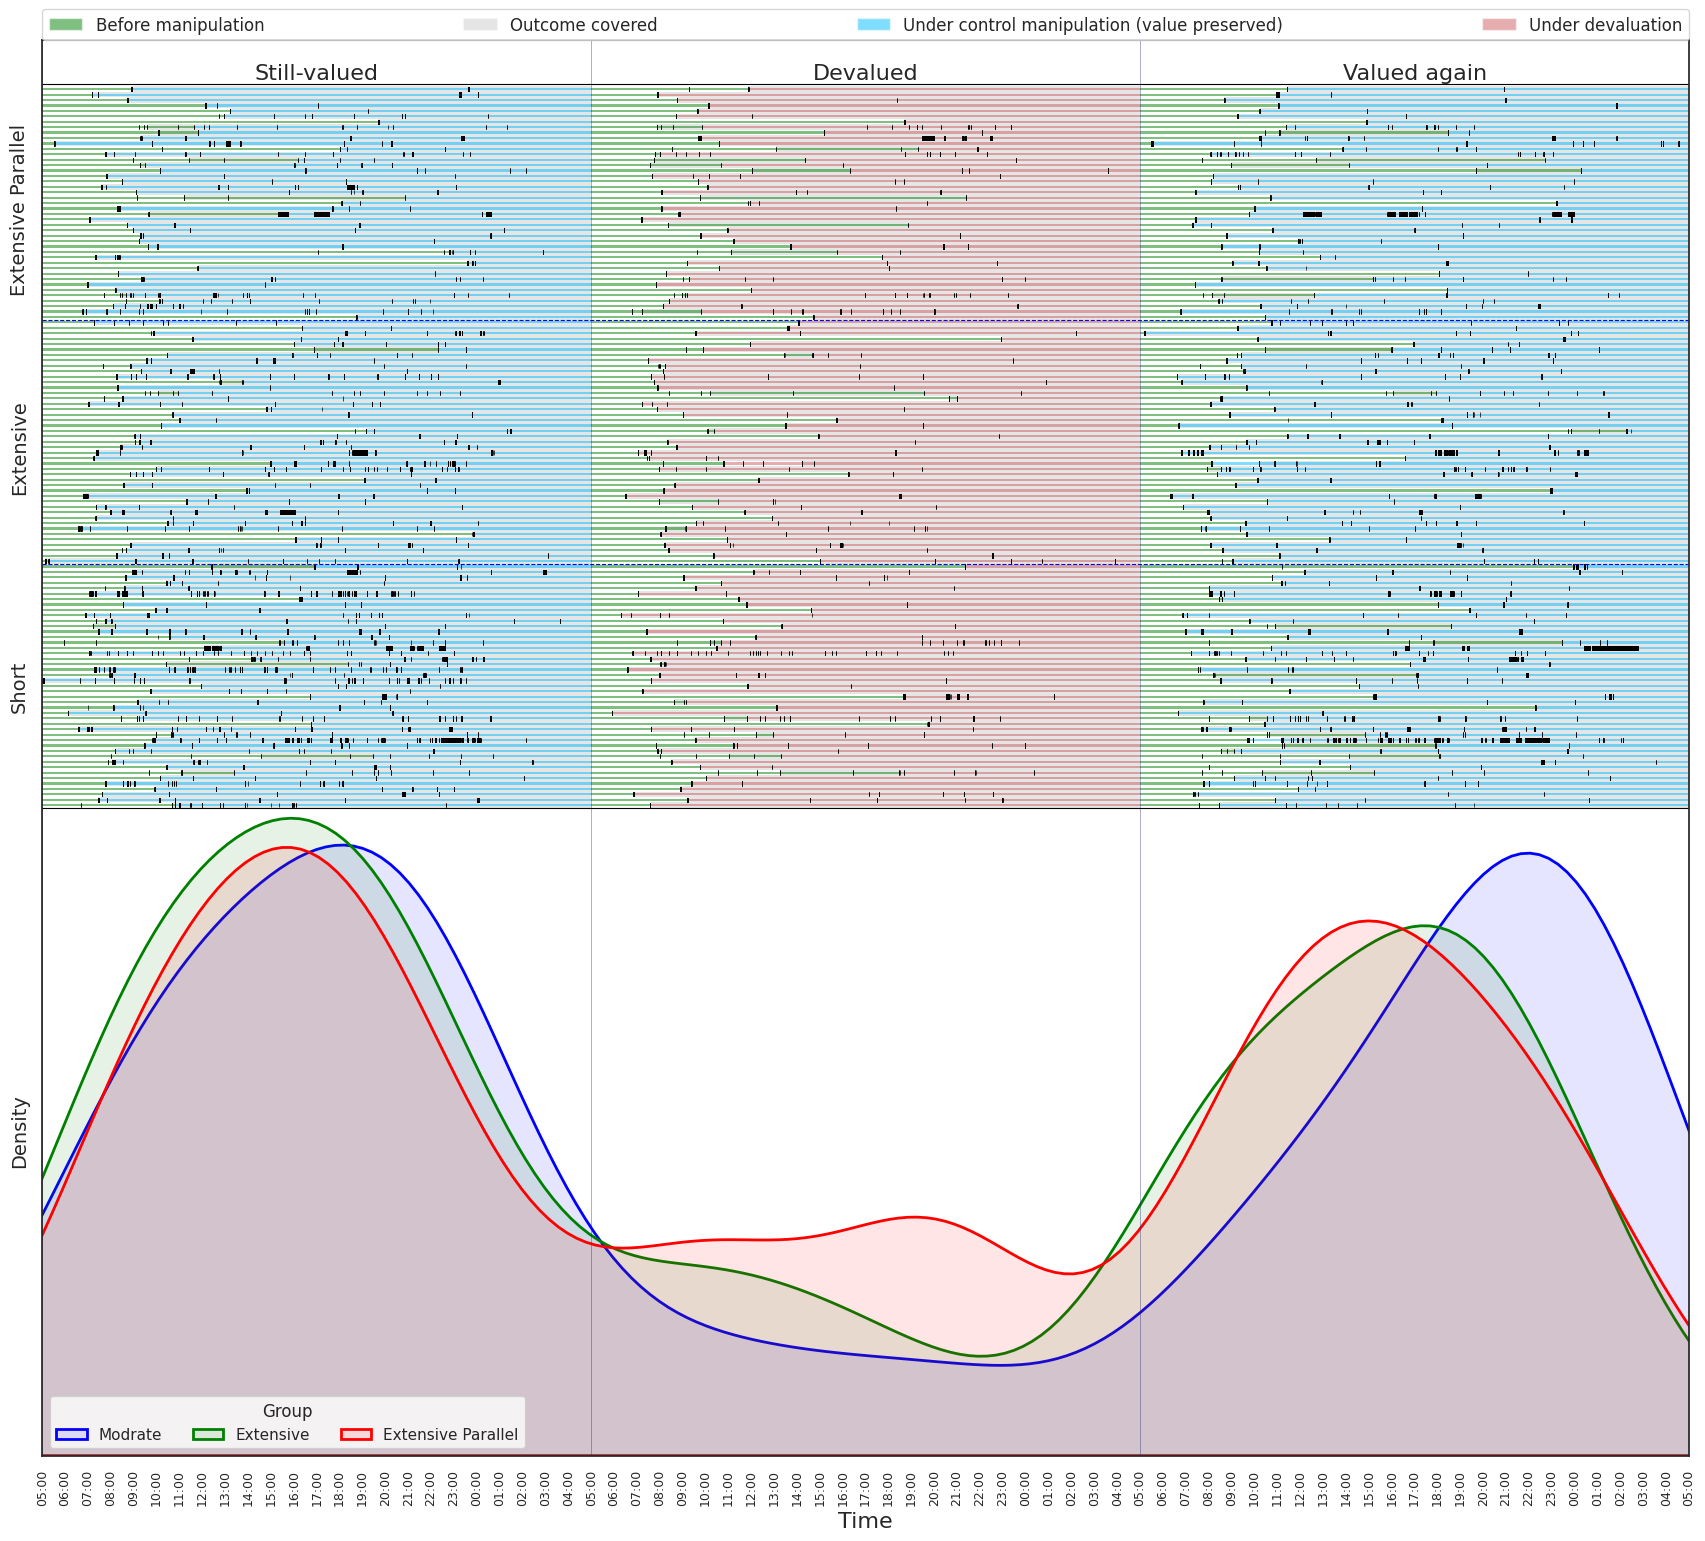

In [ ]:
#@title create the plot [large size] { form-width: "5%" }
sns.set_theme(style="white")

# Parameters:
# ------------------------
# general:
differentiatePressesByColor = False
differentiatePressesByLineHeight = False
showOnlyAlignedManipulationDays = True
figSize = (21.25,18.75)
n_groups = 3
# labels:
xlabelFontSize = 9
# scaling factors
yAxLinesScalingFactor = 0.005
yAxeStartingPointOfEvents = 0.6
line_colors = [[1,0.8,0],[1,0.4,0],[1,0,0]] if differentiatePressesByColor else ['black'] * 3
# colors:
outcome_covered_color = {'color': 'gray', 'alpha': 0.2}
before_manipulation_activated_color = {'color': 'green', 'alpha': 0.5}
under_still_devalued_control_color = {'color': 'deepskyblue', 'alpha': 0.5}
under_devaluation_color = {'color': 'indianred', 'alpha': 0.5}
# event lines:
linelengths = [0.4*yAxLinesScalingFactor, 0.6*yAxLinesScalingFactor, 0.8*yAxLinesScalingFactor] if differentiatePressesByLineHeight else [0.8*yAxLinesScalingFactor] * 3
linewidth = 0.5
# days range to present (if showOnlyAlignedManipulationDays=False)
daysRange = (1,3) if showOnlyAlignedManipulationDays else daysRange
# event lines:
lineoffsets = np.arange(start=yAxeStartingPointOfEvents, stop=np.round(n_subjects*yAxLinesScalingFactor+yAxeStartingPointOfEvents,5), step=yAxLinesScalingFactor)

# PLOT
# --------------------------
fig, axs = plt.subplots()

# Create the density plot:
kdeP = sns.kdeplot(data=timeSeriesDF, x="entry_time", hue='group', hue_order=['long_parallel','long','short'], common_norm=False, bw_method=0.2, palette=['red','green','blue'],alpha=.1, cut=True, fill=True, linewidth=2, ax=axs)
legend1 = plt.legend(loc='lower left', ncol=3, labels=['Modrate','Extensive','Extensive Parallel'], title='Group')

# create a Raster plot of app entries (including the their number of presses)
for idx, sub in enumerate(timeDict.keys()):
  axs.eventplot(timeDict[sub]['startTime'], colors=line_colors[0], lineoffsets=lineoffsets[idx] - (linelengths[2]-linelengths[0])/2,
                      linelengths=linelengths[0], linewidths=linewidth)
  axs.eventplot(timeDict[sub]['startTimeFollowedBy1Press'], colors=line_colors[1], lineoffsets=lineoffsets[idx] - (linelengths[2]-linelengths[1])/2,
                      linelengths=linelengths[1], linewidths=linewidth)
  axs.eventplot(timeDict[sub]['startTimeFollowedBy2Presses'], colors=line_colors[2], lineoffsets=lineoffsets[idx],
                      linelengths=linelengths[2], linewidths=linewidth)

# Set X axis ticks with the adequate time:
axs.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# figure setup and drawing 
# -----------------------------
fig.set_size_inches(figSize)
fig.canvas.draw()
xlim = axs.get_xlim()

# indicate seperate days (with a seperating line) and get the relevant xticks values:
endOfDayXTicks = []
middleOfDayXTicks = []
dayInd = daysRange[0]
for xtick in axs.get_xticklabels():
  if xtick.get_text()=='05:00': # create seperating lines between days
    xtick_x_value = xtick.get_unitless_position()[0]
    axs.axvline(x=xtick_x_value, color = 'midnightblue', alpha=0.5, linewidth=0.5)
    endOfDayXTicks.append(xtick_x_value)
  elif xtick.get_text()=='17:00': # add days inside mini titles:
    if showOnlyAlignedManipulationDays:
      dayTitle = ['Still-valued','Devalued', 'Valued again'][dayInd-1]
    else:
      dayTitle = 'day ' + str(dayInd)
    axs.text(xtick.get_unitless_position()[0], yAxeStartingPointOfEvents+ n_subjects*yAxLinesScalingFactor+0.1*yAxLinesScalingFactor,dayTitle,fontsize=16, va='bottom', ha='center')#, bbox=dict(facecolor='red', alpha=0.5))
    dayInd+=1
    middleOfDayXTicks.append(xtick.get_unitless_position()[0])

# draw a line seperating between the groups:
if len(data.sub_df.group.unique()) != 1: # if there is more than one group
  n_short = (commonTimeDF.subId.unique()<200).sum() * yAxLinesScalingFactor + yAxeStartingPointOfEvents
  n_long = ((commonTimeDF.subId.unique()>200) & (commonTimeDF.subId.unique()<300)).sum() * yAxLinesScalingFactor
  axs.axhline(y=n_short + n_long - yAxLinesScalingFactor/2, color = 'blue', alpha=1, linewidth=0.8, linestyle='--')
  axs.axhline(y=n_short - yAxLinesScalingFactor/2, color = 'blue', alpha=1, linewidth=0.8, linestyle='--')

# draw a line that to seperate the distributions and between the manipulatino titles:
axs.axhline(y=yAxeStartingPointOfEvents - yAxLinesScalingFactor/2, color = 'black', alpha=1, linewidth=0.8)
axs.axhline(y=lineoffsets[-1]+yAxLinesScalingFactor, color = 'black', alpha=1, linewidth=0.8)

# add rectangles that indicate outcome hiding (clouds) and manipulation (before/after):
for i, sub in enumerate(subjects):
  # place cloud rectangles:
  for hidingStartTime in timeDict[sub]['cloudsStartTimes']:
    x_position_of_hidingStartTime = mdates.date2num(hidingStartTime)
    if xlim[0] < x_position_of_hidingStartTime < xlim[1]: # check if in range of the plot 
      # Create a Rectangle patch
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_hidingStartTime][0] if [x for x in endOfDayXTicks if x >= x_position_of_hidingStartTime] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectCloudy = patches.Rectangle((x_position_of_hidingStartTime, lineoffsets[i] - yAxLinesScalingFactor/2), rectRightEndingPoint - x_position_of_hidingStartTime, yAxLinesScalingFactor,linewidth=0,edgecolor='none',facecolor=outcome_covered_color['color'], alpha=outcome_covered_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      # Add the patch to the Axes
      axs.add_patch(rectCloudy)    
  # place manipulations - still valued:
  x_position_of_still_valued =  mdates.date2num(timeDict[sub]['still_valued_indicationTrialEndTime']['time'])
  if (xlim[0] < x_position_of_still_valued < xlim[1]) & (x_position_of_still_valued.size > 0) : # check if in range of the plot & not empty
    rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
    rectStillValued = patches.Rectangle((x_position_of_still_valued, lineoffsets[i] - yAxLinesScalingFactor/5), rectRightEndingPoint - x_position_of_still_valued, yAxLinesScalingFactor/2.5,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    axs.add_patch(rectStillValued)
    # add the beginning of the day until the manipulation
    rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
    rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]- yAxLinesScalingFactor/5), x_position_of_still_valued - rectLeftStartingPoint, yAxLinesScalingFactor/2.5,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    axs.add_patch(rectStillValuedBefore)
  # place manipulations - devaluation:
  x_position_of_devaluation =  mdates.date2num(timeDict[sub]['devaluation_indicationTrialEndTime']['time'])
  if (xlim[0] < x_position_of_devaluation < xlim[1]) & (x_position_of_devaluation.size > 0) : # check if in range of the plot & not empty
    rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_devaluation][0] if [x for x in endOfDayXTicks if x >= x_position_of_devaluation] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
    rectDevalued = patches.Rectangle((x_position_of_devaluation, lineoffsets[i]- yAxLinesScalingFactor/5), rectRightEndingPoint - x_position_of_devaluation, yAxLinesScalingFactor/2.5,linewidth=0,edgecolor='none',facecolor=under_devaluation_color['color'], alpha=under_devaluation_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    axs.add_patch(rectDevalued)
    # add the beginning of the day until the manipulation
    rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_devaluation][-1] if [x for x in endOfDayXTicks if x <= x_position_of_devaluation] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
    rectDevaluedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]- yAxLinesScalingFactor/5), x_position_of_devaluation - rectLeftStartingPoint, yAxLinesScalingFactor/2.5,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    axs.add_patch(rectDevaluedBefore)
  # place manipulations - still valued AGAIN:
  x_position_of_still_valued_again =  mdates.date2num(timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['time'])
  if (xlim[0] < x_position_of_still_valued_again < xlim[1]) & (x_position_of_still_valued_again.size > 0) : # check if in range of the plot & not empty
    rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
    rectStillValued = patches.Rectangle((x_position_of_still_valued_again, lineoffsets[i]- yAxLinesScalingFactor/5), rectRightEndingPoint - x_position_of_still_valued_again, yAxLinesScalingFactor/2.5,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    axs.add_patch(rectStillValued)
    # add the beginning of the day until the manipulation
    rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
    rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]- yAxLinesScalingFactor/5), x_position_of_still_valued_again - rectLeftStartingPoint, yAxLinesScalingFactor/2.5,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    axs.add_patch(rectStillValuedBefore)


# handle legends:
legend_elements = [Patch(facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'], label='Before manipulation'),
                  Patch(facecolor=outcome_covered_color['color'], alpha=outcome_covered_color['alpha'], label='Outcome covered'),
                  Patch(facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'], label='Under control manipulation (value preserved)'),
                  Patch(facecolor=under_devaluation_color['color'], alpha=under_devaluation_color['alpha'], label='Under devaluation')]
axs.legend(handles=legend_elements, bbox_to_anchor=(0, 1.0, 1., 0.01), ncol=4, mode="expand", borderaxespad=0., fontsize=12)
plt.gca().add_artist(legend1) # add the density plot legend

# handle x axis:
axs.set_xlim(left = endOfDayXTicks[0], right = endOfDayXTicks[-1])
plt.xticks(fontsize = xlabelFontSize)
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 90)

axs.get_xaxis().set_label_text('Time', fontsize=16)

# handle y axis:
plt.ylim((0,lineoffsets[-1]+yAxLinesScalingFactor+8*yAxLinesScalingFactor))
yTicksForGroupNames = np.linspace(yAxeStartingPointOfEvents, axs.get_ylim()[1] - (yAxLinesScalingFactor+8*yAxLinesScalingFactor) ,2*n_groups+1)[np.arange(1,2*n_groups+1,2)]
plt.yticks(np.append(0.3, yTicksForGroupNames),rotation=90,ha='right', va="center")
axs.set_yticklabels(['Density', 'Short','Extensive','Extensive Parallel'], fontsize=14)
axs.get_yaxis().get_label().set_visible(False)


plt.show()


# ------------------------------ * -------------------------------


# Proportions Figures
This is completely equvalent to my main measure (gives identical results), and it allows to draw each session seperately which is nice to visualize.

>>> creating core data in a wide format.


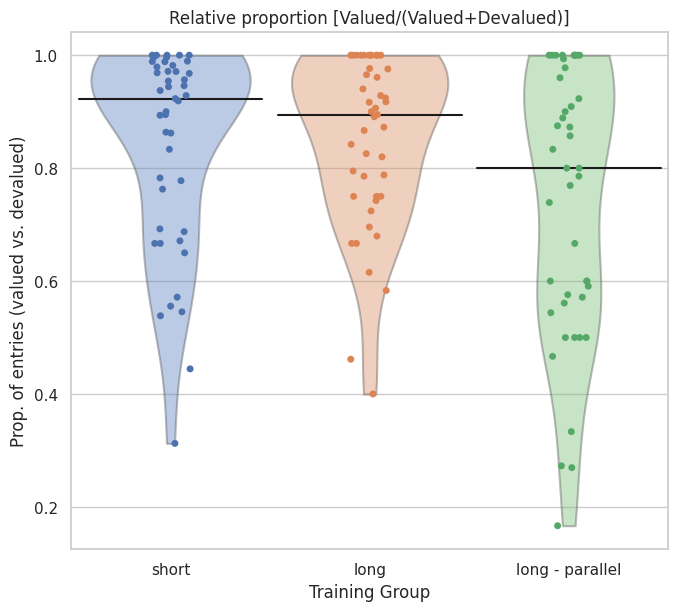

In [ ]:
#@title proportion of pre vs. deval [groups plotted together] { form-width: "5%" }
#* The variable name diffIndex is used in the code from historical reasons
sns.set_theme(style="whitegrid")

def plotGroupsAvgsSideBySide(title='', measureName='', NA2Zero=True, removeInfiniteMeasures=True, addMediansValue=False):
  # params:
  dataToPlot = core_data
  isSplitVioline=False

  n_manipulations = len(['still_valued', 'devaluation'])

  # create core data in a wide format
  print('>>> creating core data in a wide format.')
  diffIndexData = dataToPlot.reset_index(['group','manipulation'])
  diffIndexDataWide = diffIndexData.pivot(columns=['manipulation'], values=['group','n_entries'])
  groups = diffIndexDataWide['group'].iloc[:,0]
  groups.name = 'group'
  diffIndexDataWide = diffIndexDataWide.drop(labels='group', axis=1)
  diffIndexDataWide.columns = diffIndexDataWide.columns.droplevel()
  diffIndexDataWide.columns.name = ''
  diffIndexDataWide = pd.concat([groups,diffIndexDataWide], axis=1)
  # remove and swap columns:
  diffIndexDataWide = diffIndexDataWide[['group', 'still_valued', 'devaluation']]
  # change to proportions
  diffIndexData = diffIndexData[(diffIndexData.manipulation == 'still_valued') | (diffIndexData.manipulation == 'devaluation')]
  for sub in diffIndexData.index.unique():
    if diffIndexData.loc[sub,'n_entries'].sum() != 0:
      diffIndexData.loc[sub,'n_entries'] = diffIndexData.loc[sub,'n_entries'] / diffIndexData.loc[sub,'n_entries'].sum()
    else:
      diffIndexData.loc[sub,'n_entries'] = 1/n_manipulations
    if diffIndexDataWide.loc[sub,['still_valued', 'devaluation']].sum() != 0:
      diffIndexDataWide.loc[sub,['still_valued', 'devaluation']] = diffIndexDataWide.loc[sub,['still_valued', 'devaluation']]/diffIndexDataWide.loc[sub,['still_valued', 'devaluation']].sum()
    else:
      diffIndexDataWide.loc[sub,['still_valued', 'devaluation']] = 1/n_manipulations

  diffIndexData = diffIndexData[diffIndexData.manipulation == 'still_valued']

  fig, curr_ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20/3, 6), constrained_layout = True)

  # make violin/bar
  sns.violinplot(ax=curr_ax, x="group", y='n_entries', inner=None, data=diffIndexData, palette="muted", split=isSplitVioline, cut=0)
  zipStructure = zip(curr_ax.collections[::1], [0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4])
  sns.stripplot(ax=curr_ax, x="group", y='n_entries', data=diffIndexData)  # the "s" key in `scatter_kws` modifies the size of the marker
  curr_ax.axhline(y = diffIndexData.loc[diffIndexData.group == 'short_training','n_entries'].median(), xmin = 1/6-1/6.5, xmax = 1/6+1/6.5, color = 'k')
  curr_ax.axhline(y = diffIndexData.loc[diffIndexData.group == 'long_training','n_entries'].median(), xmin = 3/6-1/6.5, xmax = 3/6+1/6.5, color = 'k')
  curr_ax.axhline(y = diffIndexData.loc[diffIndexData.group == 'long_training_parallel_manipulations','n_entries'].median(), xmin = 5/6-1/6.5, xmax = 5/6+1/6.5, color = 'k')

  curr_ax.set_xticklabels(['short','long','long - parallel'])

  curr_ax.set_ylabel('Prop. of entries (valued vs. devalued)')
  curr_ax.set_xlabel('Training Group')
  curr_ax.set_title(title)

  # add transparency
  for plotObj, alpha in zipStructure:
      plotObj.set_alpha(alpha)
  
  #plt.ylim(0,100)


plotGroupsAvgsSideBySide(title='Relative proportion [Valued/(Valued+Devalued)]', measureName='entries', NA2Zero=True, removeInfiniteMeasures=True, addMediansValue=False)